## Download data from here:

https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia


chest_xray_data/
├── train/
│   ├── NORMAL/
│   └── PNEUMONIA/
├── val/
│   ├── NORMAL/
│   └── PNEUMONIA/
└── test/
    ├── NORMAL/
    └── PNEUMONIA/

In [2]:
import os
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
# Transforms

transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
])

In [6]:
# Datasets

data_dir = "chest_xray_data"
train_data = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform)
val_data = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=transform)
test_data = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

In [7]:
# Model

model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

/home/amir/anaconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/amir/anaconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [8]:
# Training

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_accs, val_accs = [], []
for epoch in range(10):
    model.train()
    correct, total = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = (torch.sigmoid(outputs) > 0.5).int()
        correct += (preds == labels.int()).sum().item()
        total += labels.size(0)
    acc = correct / total
    train_accs.append(acc)

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).int()
            correct += (preds == labels.int()).sum().item()
            total += labels.size(0)
    val_accs.append(correct / total)
    print(f"Epoch {epoch+1}, Train Acc: {train_accs[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}")

Epoch 1, Train Acc: 0.9296, Val Acc: 0.5000
Epoch 2, Train Acc: 0.9599, Val Acc: 0.5000
Epoch 3, Train Acc: 0.9695, Val Acc: 0.5000
Epoch 4, Train Acc: 0.9703, Val Acc: 0.9375
Epoch 5, Train Acc: 0.9711, Val Acc: 0.9375
Epoch 6, Train Acc: 0.9745, Val Acc: 0.8750
Epoch 7, Train Acc: 0.9827, Val Acc: 0.8750
Epoch 8, Train Acc: 0.9870, Val Acc: 0.8125
Epoch 9, Train Acc: 0.9806, Val Acc: 1.0000
Epoch 10, Train Acc: 0.9914, Val Acc: 0.9375


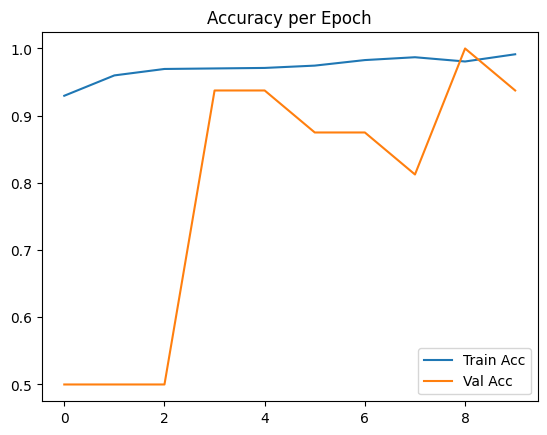

In [9]:
# Plotting

plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.legend()
plt.title("Accuracy per Epoch")
plt.show()

In [10]:
# Evaluation

y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = (torch.sigmoid(outputs) > 0.5).cpu().int().squeeze().tolist()
        y_pred.extend(preds)
        y_true.extend(labels.tolist())

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.27      0.42       234
           1       0.70      1.00      0.82       390

    accuracy                           0.73       624
   macro avg       0.85      0.63      0.62       624
weighted avg       0.81      0.73      0.67       624



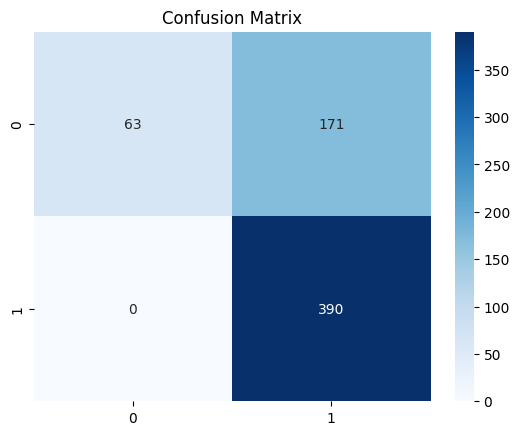

In [11]:
# Confusion Matrix

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()